## Effect of Forward Motion Compensation on L2 $\mathrm{XCO_2}$ and $\mathrm{XCH_4}$ precision

This notebook  shows the effect of FMC on the TANGO-Carbon L2 precision. Note that for the proxy product, the relative L2 precision is the same for $\mathrm XCO_2$ and $\mathrm XCH_4$. Therefore, we focus on the $\mathrm XCO_2$ precision only.

The simulations use the fmc as the determing parameter for the L2 precision giving $L_\mathrm{ref}$. For a given fmc (and sza, which is 70 degree for $L_\mathrm{ref}$), we determine the optimal temporal coadding.   
Next, we use the relation provided in Ryan's excel sheet for the exposure time<br>
$t_\mathrm{exp} = \frac{t_\mathrm{dwell}}{n_{coadd}} -\tau_\mathrm{dead}$   <br>
with the dwell time <br>
$ t_\mathrm{dwell} = 2*\frac{\Delta \mathrm{ALT}}{v_\mathrm{ground}} * \mathrm{fmc}$  <br> 
Exposure time and coadding are used to configure the IM, depending on fmc. 

Simulations are performed for the following TANGO-Carbon specific parameter settings:<br>
|parameter           | note                              |
|--------------------|-----------------------------------|
|$\Delta \mathrm{ALT} = 150$ m  | instanteneous FOV at ground level in ALT direction            |
|$v_\mathrm{ground}= 7061$ m/s | ground velocity         |
|$\tau_\mathrm{dead}=0.004$ s  | dead time               | 
|$n_{coadd}$ = 5, 10  | coadding factor                  |
|$fmc = 1,2,3,4,5$   |forward motion compensation factor.|




In [2]:
import sys
sys.path.append("/home/jochen/pythonenvs/tangoendtoend/lib64/python3.11/site-packages")
import os
import yaml
import numpy as np
from netCDF4 import Dataset
from copy import deepcopy
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib.pyplot as plt

# define  path to search for module
sys.path.append("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/")
os.chdir("/home/jochen/TANGO_E2ES/EndtoEndProject/end_to_end/examples/exp13_fmc_precision/")

### 2. Import teds modules

In [ ]:
from teds.gm.gm import geometry_module
from teds.sgm import geoscene_generation
from teds.sgm import Carbon_radiation_scene_generation
from teds.im import run_instrument_model
from teds.l1al1b import run_l1al1b
from teds.l1l2.l1bl2 import level1b_to_level2_processor

### 3. Set overall path

In [7]:
path  = '/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/'

### 4. GM

In [ ]:
#In this configurationn, the gm does not include solar and viewing geometry. It is easier to define them within the notebook
gm_config= yaml.safe_load(open('./settings/gm_config.yaml'))
#we use the nact dimension to simulate scenes with different scaling factors s and the geometry of Lref
nact = 500 
gm_config['scene_spec'] = {}
gm_config['scene_spec']['sza'] = np.zeros(nact) + 70.
gm_config['scene_spec']['saa'] = np.zeros(nact) 
gm_config['scene_spec']['vza'] = np.zeros(nact) 
gm_config['scene_spec']['vaa'] = np.zeros(nact) 

geometry_module(gm_config)


#### 5. SGM-GEO

In [ ]:
nact = 500
albedo = np.ones(nact)*0.15
sgmgeo_config= yaml.safe_load(open('./settings/sgmgeo_config.yaml'))
sgmgeo_config['scene_spec']={}
sgmgeo_config['scene_spec']['albedo'] = albedo
geoscene_generation(sgmgeo_config)

#### 6. SGM-RAD

In [ ]:
sgmrad_config= yaml.safe_load(open('./settings/sgmrad_config.yaml'))
Carbon_radiation_scene_generation(sgmrad_config)

### 7. Determine exposure time for given fmc and sza

This function is not included in the IM as it simulates the operation of the instrument. 

In [ ]:
def exposure_time(
    sza: float,
    ifmc: int) -> tuple[int, float]:
    """ 
        This function simulates optimal fmc-temporal coadding 
        operation of the instrument. It is based in analysis of
        Paul and Ryan.
        input:
        sza      solar zenith angle [degree]
        ifmc     forward motion compensation factor (only integer)
        output:
        tau_exp  exposure time
        noadd    number of temporal coadding
    """
    
    Delta_ACT = 150    #m
    v_ground  = 7061   #m/s
    tau_dead  = 0.004  #s

    if(ifmc not in [1,2,3,4,5]):
        sys.exit('input ifmc out of range')

    #noadd_fmc_sza are the optimal temporal coadding factors as a function of fmc and sza. 
    #number are derived by P.Tol adn R. Cooney 
    noadd_fmc_sza={}
    noadd_fmc_sza[4] = np.array(
        [[0., 35., 36., 46., 47., 54., 55., 61., 62., 68., 69., 70.],
        [ 9.,  9.,  8.,  8.,  7.,  7.,  6.,  6.,  5.,  5.,  4.,  4.]])
    noadd_fmc_sza[3] = np.array(
        [[0., 41., 42., 52., 53., 61., 62., 69., 70.],
        [ 7.,  7.,  6.,  6.,  5.,  5.,  4.,  4.,  3.]])
    noadd_fmc_sza[2] = np.array(
        [[0., 31., 32., 48., 49., 61., 62., 70.],
        [ 6.,  6.,  5.,  5.,  4.,  4.,  3.,  3.]])
    noadd_fmc_sza[1] = np.array(
        [[0., 41., 42., 61., 62., 70.],
        [ 4.,  4.,  3.,  3.,  2.,  2.]])
    noadd_fmc_sza[0] = np.array(
        [[0., 61., 62., 70.],
         [2.,  2.,  1.,  1.]])

    #Determine the optimal temporal coadding using the analysis by Paul and Ryan 
    #Use the int function to simulate steps 

    noadd = int(np.interp(sza, noadd_fmc_sza[ifmc-1][0,:], noadd_fmc_sza[ifmc-1][1,:]))

    tau_dwell = 2* Delta_ACT/v_ground * float(ifmc)
    tau_exp   = tau_dwell/noadd -tau_dead

    return noadd, tau_exp

### 7. Loop IM, L1AL1B and L2 processor over different FMCs

Run the instrument model for each scaled scenes using a seperate call 

In [ ]:
# mean sza of the scene
gm = Dataset('/home/jochen/TANGO_E2ES/EndtoEndProject/data/interface_data/gm/Tango_Carbon_gm_exp13.nc')
sza = np.mean(gm['solar_zenith'][:])

# calculate exposure time and optimal binning as a function of fmc for Lref
nfmc = 5
fmc = np.arange(nfmc)+1
expt = np.zeros(nfmc)
nadd = np.zeros(nfmc, dtype='int16')

for ifmc in fmc:
    coadd,expot = exposure_time(sza,ifmc)
    expt[ifmc-1] = expot   #save it in a numpy array for visualization
    nadd[ifmc-1] = coadd    #save it in a numpy array for visualization

    cfmc = str_bcoeff = "%.1f" % (ifmc)
    ccoadd = str_bcoeff = "%.1f" % (coadd)
    # instrument model
    im_config= yaml.safe_load(open('./settings/im_config.yaml'))
    im_config['detector']['exposure_time'] = expot
    im_config['detector']['nr_coadditions'] = coadd
    run_instrument_model(im_config)

    # l1al1b processor
    l1al1b_config= yaml.safe_load(open('./settings/l1al1b_config.yaml'))
    l1al1b_config['io']['l1b'] = path+'level1b/Tango_Carbon_l1b_exp13_fmc'+cfmc+'.nc'
    l1al1b_config['stray']['van_cittert_steps']= 4
    run_l1al1b(l1al1b_config)

    # l2 processor
    l1bl2_config= yaml.safe_load(open('./settings/l1bl2_config.yaml'))
    l1bl2_config['io_files']['output_l2'] = path+'level2/Tango_Carbon_l2_exp13_fmc'+cfmc+'.nc'
    l1bl2_config['io_files']['input_l1b'] = path+'level1b/Tango_Carbon_l1b_exp13_fmc'+cfmc+'.nc'
    level1b_to_level2_processor(l1bl2_config)

### 8. L1B visualization
This cell generates a plot of the radiance $\mathrm{L_{ref}}$ and the SNR depending on fmc and nadd. 

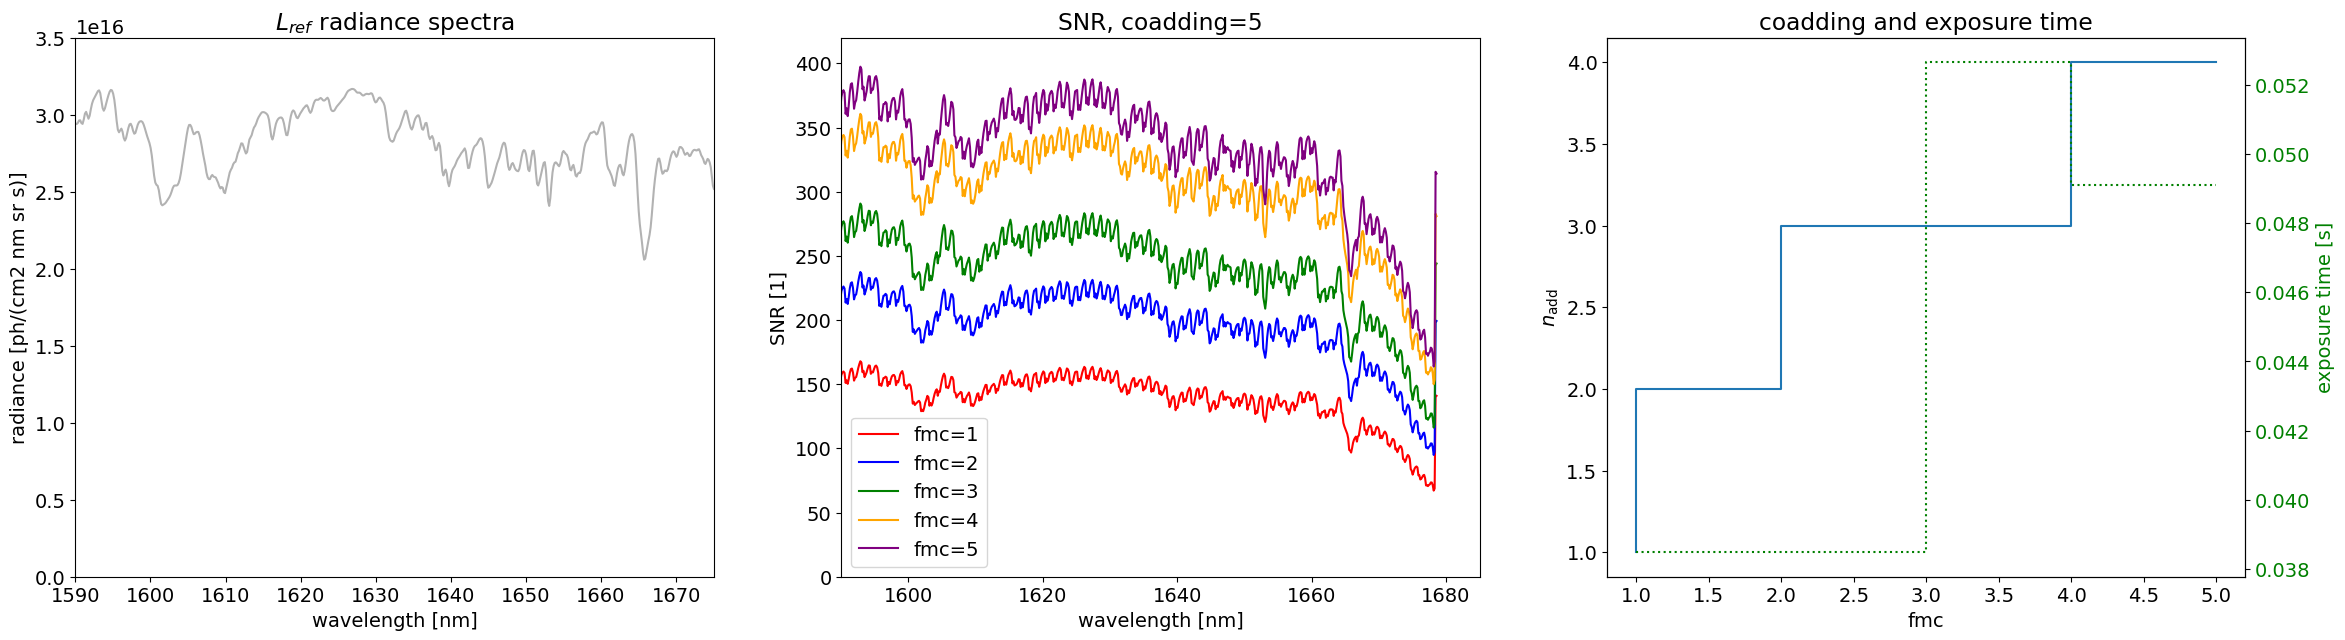

In [ ]:
nwave = 640
nfmc = 5

wave_mean = np.zeros([nfmc, nwave])
rad_mean  = np.zeros([nfmc, nwave])
snr_mean  = np.zeros([nfmc, nwave])
plt.rcParams.update({'font.size': 14,})

fmc = np.arange(nfmc)+1
expt = np.zeros(nfmc)
nadd = np.zeros(nfmc, dtype='int16')

for ifmc in fmc:
    nadd[ifmc-1], expt[ifmc-1] = exposure_time(sza,ifmc)
    cfmc = str_bcoeff = "%.1f" % (ifmc)

    filen = path+'level1b/Tango_Carbon_l1b_exp13_fmc'+cfmc+'.nc'
    l1b_data = Dataset(filen)

    wave_mean[ifmc-1,:] = np.mean(l1b_data['observation_data/wavelength'][:,:],axis=0)
    rad_mean[ifmc-1,:]  = np.mean(l1b_data['observation_data/radiance'][0,:,:],axis=0)
    snr_mean[ifmc-1,:]  = np.mean(l1b_data['observation_data/radiance'][0,:,:]/l1b_data['observation_data/radiance_stdev'][0,:,:],axis=0)

fig = plt.figure(figsize=(28, 7), dpi=100,)
ax0 = fig.add_subplot(131)
ax0.plot(wave_mean[0,:], rad_mean[0,:], color = 'grey', alpha = 0.6, label = 'lbl')
ax0.set_xlabel('wavelength [nm]')
ax0.set_ylabel('radiance [ph/(cm2 nm sr s)]')
ax0.set_ylim([0.0,3.5E16])
ax0.set_xlim([1590,1675])
ax0.set_title('$L_{ref}$ radiance spectra')
#ax0.legend()

ax1 = fig.add_subplot(132)
ax1.plot(wave_mean[0,:], snr_mean[0,:], color = 'red',    label = 'fmc=1',)
ax1.plot(wave_mean[1,:], snr_mean[1,:], color = 'blue',   label = 'fmc=2',)
ax1.plot(wave_mean[2,:], snr_mean[2,:], color = 'green',  label = 'fmc=3',)
ax1.plot(wave_mean[3,:], snr_mean[3,:], color = 'orange', label = 'fmc=4',)
ax1.plot(wave_mean[4,:], snr_mean[4,:], color = 'purple', label = 'fmc=5',)
ax1.set_xlim([1590,1685])
ax1.set_ylim([0.0,420])
ax1.set_title('SNR, coadding=5')
ax1.set_xlabel('wavelength [nm]')
ax1.set_ylabel('SNR [1]')
ax1.legend()

ax2 = fig.add_subplot(133)
ax2.step(fmc,nadd,label='temporal coadding')
ax2.set_title('coadding and exposure time')
ax2.set_xlabel('fmc')
ax2.set_ylabel('$n_\mathrm{add}$')
ax3 = ax2.twinx() 
ax3.set_ylabel('exposure time [s]', color = 'green') 
ax3.step(fmc, expt, color = 'green',label='exposure time',linestyle='dotted') 
ax3.tick_params(axis ='y', labelcolor = 'green') 

### 8. L2 visualization

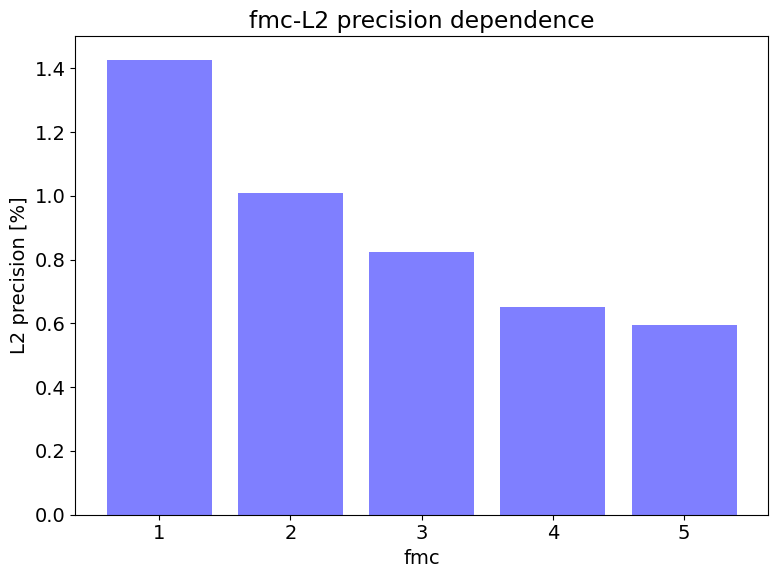

In [17]:
nfmc = 5
fmc = np.arange(nfmc)+1
XCO2_ref = 410.
prec_xco2_proxy = np.zeros(nfmc)
plt.rcParams.update({'font.size': 14,})

for ifmc in fmc:
    cfmc = str_bcoeff = "%.1f" % (ifmc)
    l2filen = path+'level2/Tango_Carbon_l2_exp13_fmc'+cfmc+'.nc'
    l2_data = Dataset(l2filen)
    prec_xco2_proxy[ifmc-1] = np.mean(deepcopy(l2_data['precision XCO2 proxy'][:]).flatten())

plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(fmc, prec_xco2_proxy/XCO2_ref*100., color = 'blue', alpha = 0.5)
ax.set_title('fmc-L2 precision dependence')
ax.set_xlabel('fmc')
ax.set_ylabel('L2 precision [%]')
plt.tight_layout()
ax.set_ylim([0.0, 1.5])
plt.show()

### Conclusions
The analysis shows that
* fmc reduces the L2 precision well below 1 %. For fmc=5, the predicted L2 proxy precision is 0.6 %. 
* The correspsonding SNR in the spectral continuum is < 400